# PyTorch Computer Vision

## 1. Import Libraries

In [5]:
# !pip install torcheval torchinfo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.data import DataLoader
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
)
from torchinfo import summary
from torchvision import datasets, transforms

import engine
import utils

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

RAMDOM_SEED = 42

%load_ext autoreload
%autoreload 2

torch: 2.1.0+cu121
torchvision: 0.16.0+cu121
device: cuda


## 2. Get Dataset

### 2.1 Loading FashionMNIST dataset

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [3]:
print(f"train data: {len(train_data)}")
print(f"test data : {len(test_data)}")

class_names = train_data.classes
NUM_CLASSES = len(class_names)
print(f"number of classes: {NUM_CLASSES}")
print(f"\nclass names:\n{class_names}")

class_to_idx = train_data.class_to_idx
print(f"\nclass to index:\n{class_to_idx}")

targets = train_data.targets
print(f"\ntargets:\n{targets}")

image, label = train_data[0]
INPUT_IMAGE_SIZE = image.shape
print(f"\nimage shape:\n{INPUT_IMAGE_SIZE} -> [color_channels, height, width]")
print(f"\nimage :\n{label}")
print(f"\nimage label:\n{class_names[label]}")

train data: 60000
test data : 10000
number of classes: 10

class names:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class to index:
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

targets:
tensor([9, 0, 0,  ..., 3, 0, 5])

image shape:
torch.Size([1, 28, 28]) -> [color_channels, height, width]

image :
9

image label:
Ankle boot


### 2.2 Visualizing our data

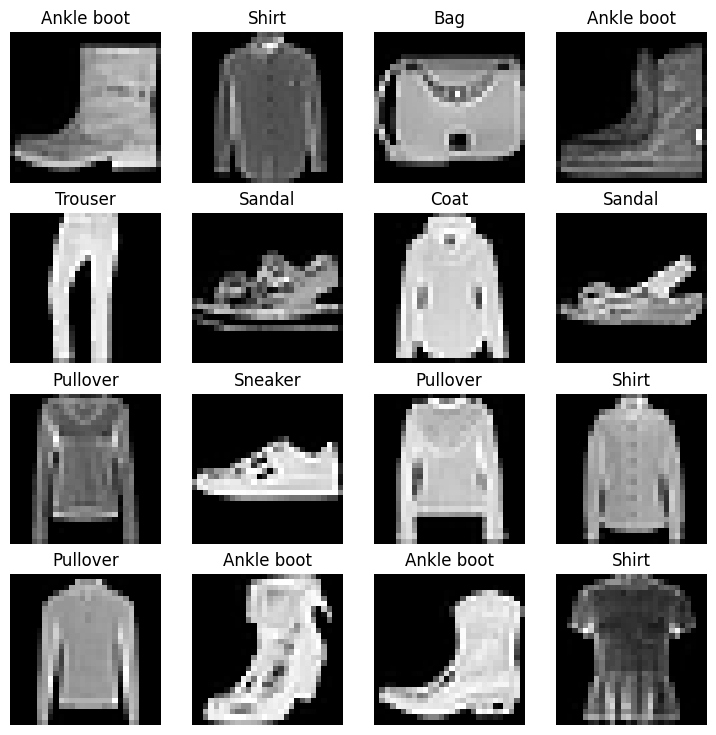

In [4]:
torch.manual_seed(RAMDOM_SEED)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 3. Prepare DataLoader

These smaller chunks are called batches or mini-batches and can be set by the batch_size parameter.

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"train dataloader: {train_dataloader}")
print(f"test Dataloader : {test_dataloader}")
print(f"length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} ({len(train_dataloader)*BATCH_SIZE})")
print(f"length of test dataloader : {len(test_dataloader)} batches of {BATCH_SIZE} ({len(test_dataloader)*BATCH_SIZE})")

train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7b08bb51a8c0>
test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7b08bb51ac20>
length of train dataloader: 1875 batches of 32 (60000)
length of test dataloader : 313 batches of 32 (10016)


In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
print(f"train features batch shape: {train_features_batch.shape}")
print(f"train labels batch shape  : {train_labels_batch.shape}")

train features batch shape: torch.Size([32, 1, 28, 28])
train labels batch shape  : torch.Size([32])


Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


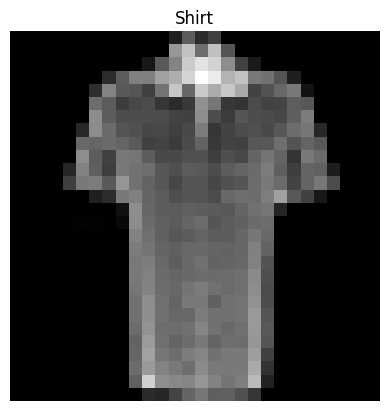

In [7]:
torch.manual_seed(RAMDOM_SEED)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 4. Model 0: Build a baseline model

### 4.1 Create the base model

In [8]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [9]:
torch.manual_seed(RAMDOM_SEED)

model_0 = FashionMNISTModelV0(
    input_shape=28 * 28,
    hidden_units=10,
    output_shape=NUM_CLASSES,
)
model_0.to(device)
summary(
    model_0,
    input_size=(BATCH_SIZE, 28 * 28),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
FashionMNISTModelV0                      [32, 784]                 [32, 10]                  --                        True
├─Sequential: 1-1                        [32, 784]                 [32, 10]                  --                        True
│    └─Flatten: 2-1                      [32, 784]                 [32, 784]                 --                        --
│    └─Linear: 2-2                       [32, 784]                 [32, 10]                  7,850                     True
│    └─Linear: 2-3                       [32, 10]                  [32, 10]                  110                       True
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.14

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
activation_fn = lambda x: torch.argmax(x, dim=1)

### 4.2 Train the base model or load pre-trained state_dict

In [11]:
model_0.load_state_dict(torch.load(f="./models/model_0.pth"))
model_0_results = utils.load_model_results("./models/model_0.json")

In [21]:
# model_0_results = engine.train(
#     epochs=20,
#     model=model_0,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     activation_fn=activation_fn,
#     accuracy_fn=multiclass_accuracy,
#     device=device,
# )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   1 | train_loss: 0.5891 | train_acc: 0.7925 | test_loss: 0.5327 | test_acc: 0.8171
Epoch:   2 | train_loss: 0.4771 | train_acc: 0.8321 | test_loss: 0.6142 | test_acc: 0.7871
Epoch:   3 | train_loss: 0.4540 | train_acc: 0.8406 | test_loss: 0.4775 | test_acc: 0.8327
Epoch:   4 | train_loss: 0.4419 | train_acc: 0.8449 | test_loss: 0.4600 | test_acc: 0.8375
Epoch:   5 | train_loss: 0.4348 | train_acc: 0.8481 | test_loss: 0.4756 | test_acc: 0.8325
Epoch:   6 | train_loss: 0.4310 | train_acc: 0.8474 | test_loss: 0.4551 | test_acc: 0.8400
Epoch:   7 | train_loss: 0.4260 | train_acc: 0.8518 | test_loss: 0.4621 | test_acc: 0.8351
Epoch:   8 | train_loss: 0.4218 | train_acc: 0.8510 | test_loss: 0.4541 | test_acc: 0.8403
Epoch:   9 | train_loss: 0.4202 | train_acc: 0.8513 | test_loss: 0.4755 | test_acc: 0.8347
Epoch:  10 | train_loss: 0.4172 | train_acc: 0.8547 | test_loss: 0.4442 | test_acc: 0.8408
Epoch:  11 | train_loss: 0.4145 | train_acc: 0.8535 | test_loss: 0.4536 | test_acc: 0.8367

### 4.3 Plot loss and accuracy curves

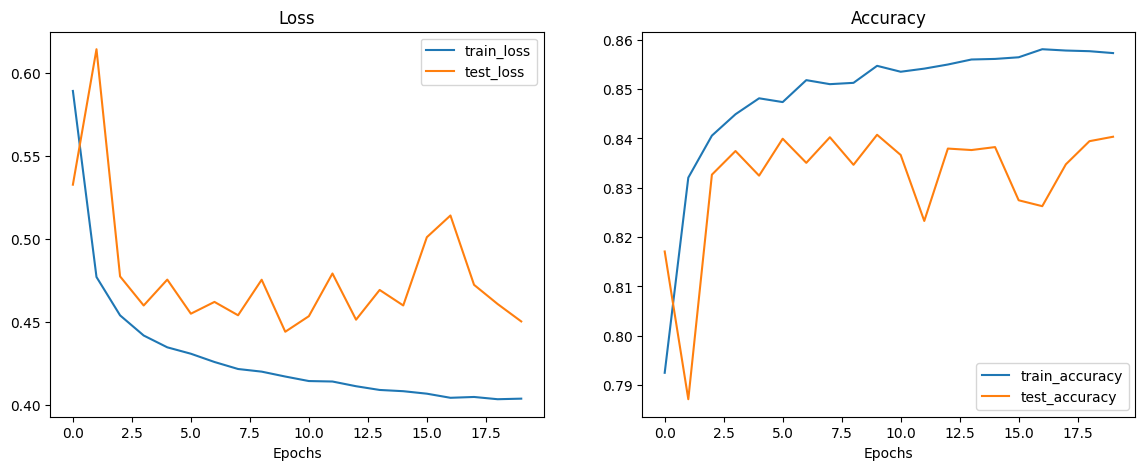

In [12]:
utils.plot_loss_curves(model_0_results, figsize=(14, 5))

### 4.4 Make predictions and get model_0 results

In [13]:
model_0_result = engine.test_step(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model_0.__class__.__name__
model_loss = model_0_result[0]
model_accuracy = model_0_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for FashionMNISTModelV0:
loss = 0.450, accuracy = 0.840


### 4.5 Saving the model

In [24]:
utils.save_model(
    model=model_0,
    target_dir="models",
    model_name="model_0.pth",
    results=model_0_results,
)

[INFO] Saving model to: models/model_0.pth
[INFO] Saving training results to: models/model_0.json


### 4.6 Make and evaluate random predictions

#### 4.6.1 Create samples from data

In [14]:
samples, lables = utils.create_samples(data=test_data, num_samples=9, random_seed=RAMDOM_SEED)
lables

[5, 1, 7, 4, 3, 0, 4, 7, 1]

#### 4.6.2 Make predictions

In [15]:
pred_labels = utils.make_predictions(model=model_0, samples=samples, device=device)
pred_labels

[5, 3, 7, 2, 3, 0, 4, 7, 1]

#### 4.6.3 Plot predictions

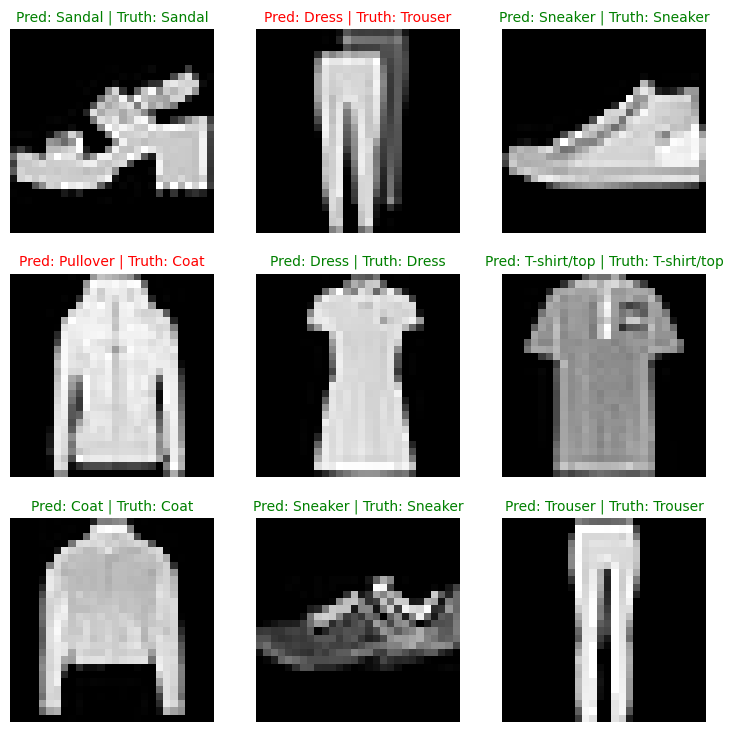

In [16]:
utils.plot_predictions(
    samples=samples,
    lables=lables,
    pred_labels=pred_labels,
    class_names=class_names,
)

### 4.7 Evaluation with confusion matrix

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

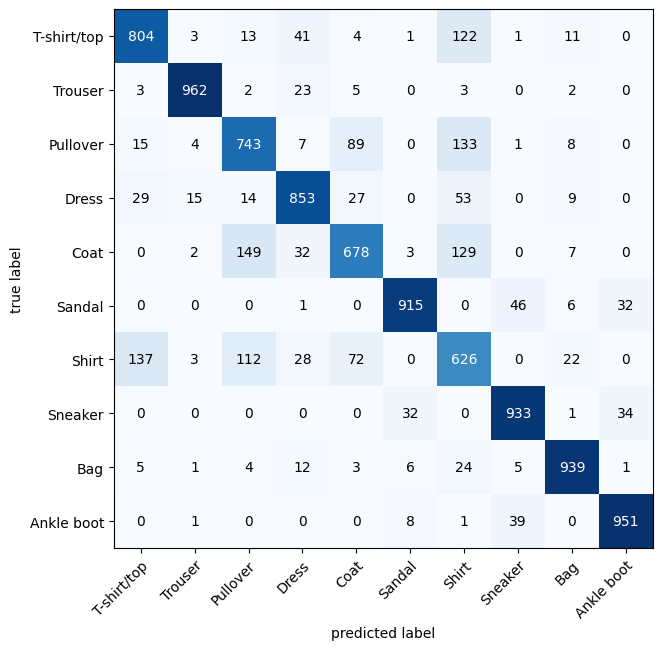

In [17]:
y_preds = engine.evaluation_step(
    model=model_0,
    data_loader=test_dataloader,
    activation_fn=activation_fn,
    device=device,
)
cm = multiclass_confusion_matrix(y_preds, test_data.targets, NUM_CLASSES)
fig, ax = plot_confusion_matrix(cm.numpy(), class_names=class_names, figsize=(10, 7))

## 5. Model 1: Building a Convolutional Neural Network (CNN)

### 5.1 Create the CNN model

In [18]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, # number of image channels
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2,
            ),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 7 * 7,
                out_features=output_shape,
            ),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [19]:
torch.manual_seed(RAMDOM_SEED)

model_1 = FashionMNISTModelV1(
    input_shape=1,
    hidden_units=10,
    output_shape=NUM_CLASSES,
)
model_1.to(device)
summary(
    model_1,
    input_size=(BATCH_SIZE, 1, 28, 28),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
FashionMNISTModelV1                      [32, 1, 28, 28]           [32, 10]                  --                        --                        True
├─Sequential: 1-1                        [32, 1, 28, 28]           [32, 10, 14, 14]          --                        --                        True
│    └─Conv2d: 2-1                       [32, 1, 28, 28]           [32, 10, 28, 28]          100                       [3, 3]                    True
│    └─ReLU: 2-2                         [32, 10, 28, 28]          [32, 10, 28, 28]          --                        --                        --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          [32, 10, 28, 28]          910                       [3, 3]                    True
│    └─ReLU: 2-4                         [32, 10, 28, 28]          [32, 10, 28, 28]          --  

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
activation_fn = lambda x: torch.argmax(x, dim=1)

### 5.2 Train the base model or load pre-trained state_dict

In [21]:
model_1.load_state_dict(torch.load(f="./models/model_1.pth"))
model_1_results = utils.load_model_results("./models/model_1.json")

In [36]:
# model_1_results = engine.train(
#     epochs=20,
#     model=model_1,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     activation_fn=activation_fn,
#     accuracy_fn=multiclass_accuracy,
#     device=device,
# )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:   1 | train_loss: 0.5794 | train_acc: 0.7891 | test_loss: 0.4003 | test_acc: 0.8516
Epoch:   2 | train_loss: 0.3564 | train_acc: 0.8692 | test_loss: 0.3671 | test_acc: 0.8667
Epoch:   3 | train_loss: 0.3189 | train_acc: 0.8851 | test_loss: 0.3238 | test_acc: 0.8786
Epoch:   4 | train_loss: 0.2984 | train_acc: 0.8911 | test_loss: 0.3246 | test_acc: 0.8841
Epoch:   5 | train_loss: 0.2857 | train_acc: 0.8957 | test_loss: 0.3169 | test_acc: 0.8852
Epoch:   6 | train_loss: 0.2776 | train_acc: 0.8989 | test_loss: 0.2977 | test_acc: 0.8933
Epoch:   7 | train_loss: 0.2681 | train_acc: 0.9024 | test_loss: 0.3021 | test_acc: 0.8871
Epoch:   8 | train_loss: 0.2606 | train_acc: 0.9054 | test_loss: 0.2976 | test_acc: 0.8950
Epoch:   9 | train_loss: 0.2539 | train_acc: 0.9072 | test_loss: 0.2829 | test_acc: 0.8994
Epoch:  10 | train_loss: 0.2501 | train_acc: 0.9085 | test_loss: 0.2921 | test_acc: 0.8981
Epoch:  11 | train_loss: 0.2447 | train_acc: 0.9113 | test_loss: 0.2989 | test_acc: 0.8970

### 5.3 Plot loss and accuracy curves

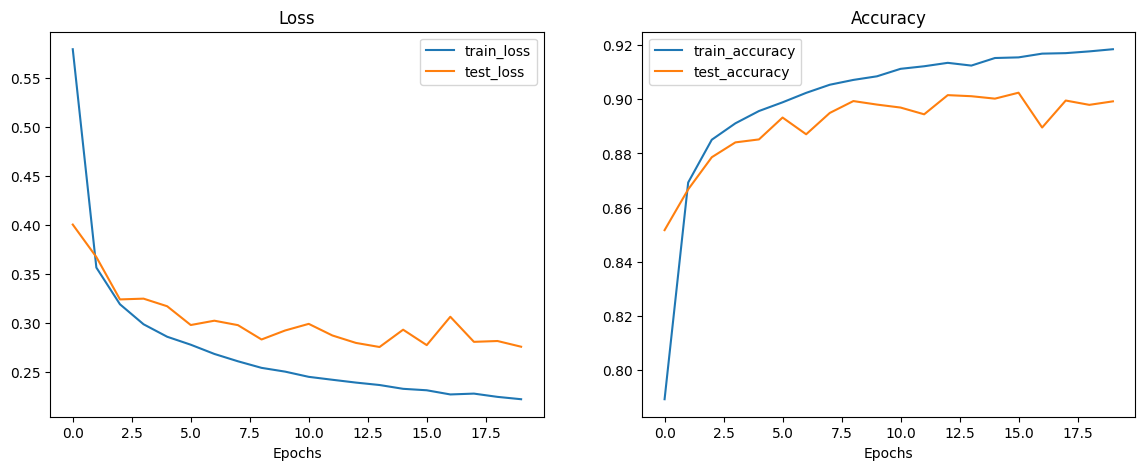

In [22]:
utils.plot_loss_curves(model_1_results, figsize=(14, 5))

### 5.4 Make predictions and get model_1 results

In [23]:
model_1_result = engine.test_step(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model_1.__class__.__name__
model_loss = model_1_result[0]
model_accuracy = model_1_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for FashionMNISTModelV1:
loss = 0.276, accuracy = 0.899


### 5.5 Saving the model

In [24]:
utils.save_model(
    model=model_1,
    target_dir="models",
    model_name="model_1.pth",
    results=model_1_results,
)

[INFO] Saving model to: models/model_1.pth
[INFO] Saving training results to: models/model_1.json


### 5.6 Make and evaluate random predictions

#### 5.6.1 Create samples from data

In [25]:
samples, lables = utils.create_samples(data=test_data, num_samples=9, random_seed=RAMDOM_SEED)
lables

[5, 1, 7, 4, 3, 0, 4, 7, 1]

#### 5.6.2 Make predictions

In [26]:
pred_labels = utils.make_predictions(model=model_1, samples=samples, device=device)
pred_labels

[5, 1, 7, 2, 3, 6, 4, 7, 1]

#### 5.6.3 Plot predictions

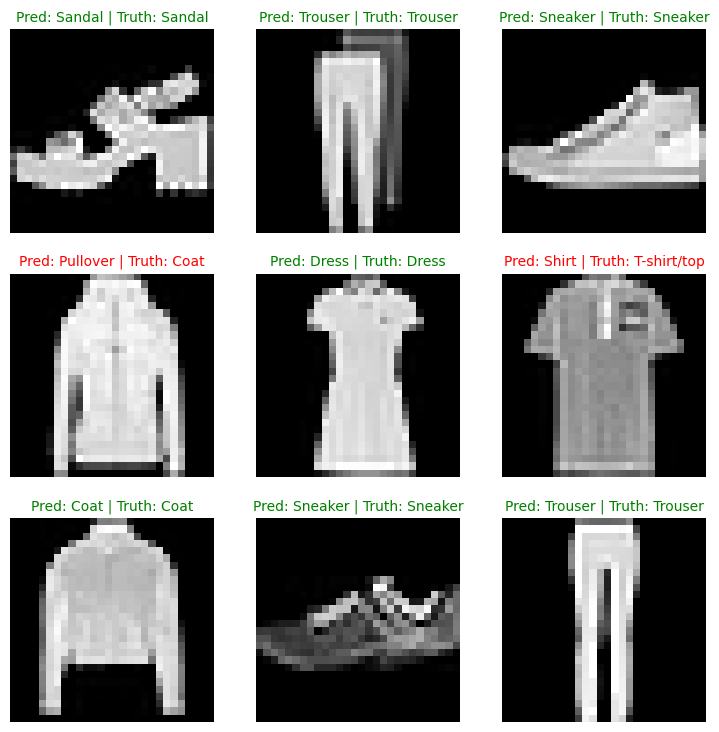

In [27]:
utils.plot_predictions(
    samples=samples,
    lables=lables,
    pred_labels=pred_labels,
    class_names=class_names,
)

### 5.7 Evaluation with confusion matrix

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

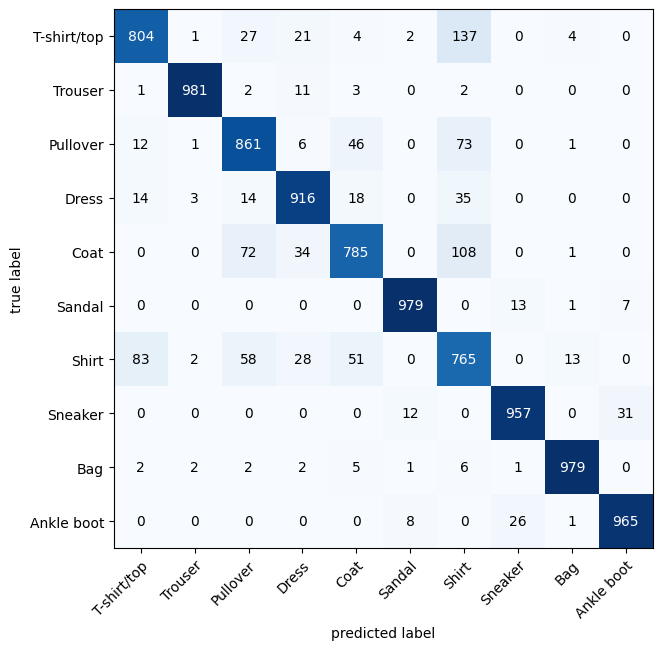

In [28]:
y_preds = engine.evaluation_step(
    model=model_1,
    data_loader=test_dataloader,
    activation_fn=activation_fn,
    device=device,
)
cm = multiclass_confusion_matrix(y_preds, test_data.targets, NUM_CLASSES)
fig, ax = plot_confusion_matrix(cm.numpy(), class_names=class_names, figsize=(10, 7))

## 6. Compare model results

In [29]:
compare_results = pd.DataFrame({
    "model": [model_0.__class__.__name__, model_1.__class__.__name__],
    "loss": [model_0_result[0], model_1_result[0]],
    "accuracy": [model_0_result[1], model_1_result[1]],
})
compare_results

,model,loss,accuracy
0,FashionMNISTModelV0,0.450395,0.840355
1,FashionMNISTModelV1,0.275516,0.899261


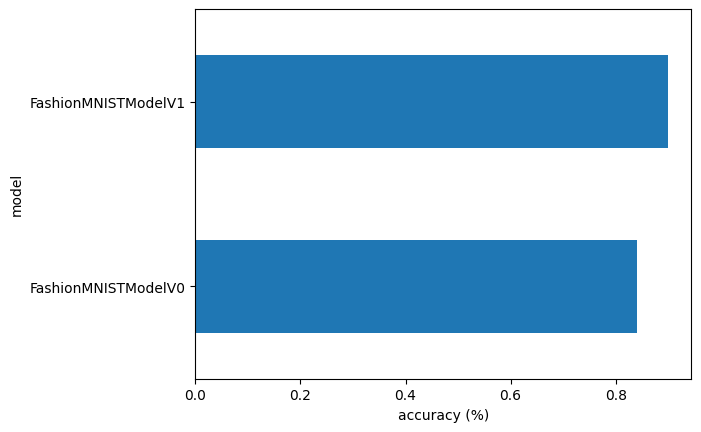

In [30]:
compare_results.set_index("model")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");